# Tools and dependencies

In [9]:
%pip install httpx
%pip install pandas
%pip install scipy
%pip install matplotlib
%pip install tables

You should consider upgrading via the '/Users/alexander/Projects/senso-rehab/imu-gesture-recognition-notebook/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/alexander/Projects/senso-rehab/imu-gesture-recognition-notebook/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/alexander/Projects/senso-rehab/imu-gesture-recognition-notebook/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/alexander/Projects/senso-rehab/imu-gesture-recognition-notebook/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
  Using cached tables-3.7.0-cp310-cp310-macosx_10_9_x86_64.whl (6.0 MB)


In [1]:
import io
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.spatial import transform as scipy_transform

In [2]:
import os

import httpx


class Clickhouse:
    credentials = {
        "user": os.environ['CLICKHOUSE_USER'],
        "password": os.environ['CLICKHOUSE_PASSWORD'],
    }
    url = os.environ['CLICKHOUSE_URL']

    def __init__(self):
        self._httpx_client = httpx.Client()

    def post(
        self,
        query: str,
        headers: dict = None,
        content: bytes = None,
    ) -> str:
        response = self._httpx_client.post(
            url=self.url,
            params={
                "query": query,
                **self.credentials,
            },
            headers=headers,
            content=content,
        )
        return response.text

    def get(
        self,
        query: str,
        headers: dict = None,
    ) -> str:
        response = self._httpx_client.get(
            url=self.url,
            params={
                "query": query,
                **self.credentials,
            },
            headers=headers,
        )
        return response.text


# Load data

In [3]:
df = None
try:
    df = pd.read_hdf('./data/dataset_gross.h5')
except FileNotFoundError:
    pass

In [4]:
if df is None:
    ch = Clickhouse()
    pos_csv_str = ch.get('SELECT * FROM raw_data FORMAT CSV')
    print(pos_csv_str[:200])

In [5]:
if df is None:
    df = pd.read_csv(
        io.StringIO(pos_csv_str),
        names=[
            'game_result_id', 'game_id', 'patient_id', 'exercise_id', 'timestamp', 'src', 'side',
            'h_rssi', 'h_gain', 'g_rssi', 'g_gain', 'forearm_quat_x',
            'forearm_quat_y', 'forearm_quat_z', 'forearm_quat_w', 'forearm_lia_x',
            'forearm_lia_y', 'forearm_lia_z', 'forearm_grv_x', 'forearm_grv_y',
            'forearm_grv_z', 'shoulder_quat_x', 'shoulder_quat_y',
            'shoulder_quat_z', 'shoulder_quat_w', 'shoulder_lia_x',
            'shoulder_lia_y', 'shoulder_lia_z', 'shoulder_grv_x', 'shoulder_grv_y',
            'shoulder_grv_z', 'position_type'
        ],
    )
    df.to_hdf('./data/dataset_gross.h5', key='df', mode='w')

In [6]:
df.head(10)

,game_result_id,game_id,patient_id,exercise_id,timestamp,src,side,h_rssi,h_gain,g_rssi,...,shoulder_quat_y,shoulder_quat_z,shoulder_quat_w,shoulder_lia_x,shoulder_lia_y,shoulder_lia_z,shoulder_grv_x,shoulder_grv_y,shoulder_grv_z,position_type
0,13284,12,493,7,2022-12-16 04:57:49.235,00:00:00:00:00:00,2,0,0,0,...,0.555235,0.308700,0.396314,-0.126,0.055,0.040,-6.033,-7.673,-1.329,0
1,13284,12,493,7,2022-12-16 04:57:49.251,00:00:00:00:00:00,2,0,0,0,...,0.555276,0.308243,0.396410,0.034,0.072,0.049,-5.940,-7.736,-1.443,0
2,13284,12,493,7,2022-12-16 04:57:49.267,00:00:00:00:00:00,2,0,0,0,...,0.555273,0.307639,0.396677,0.110,0.067,-0.012,-5.856,-7.712,-1.500,0
3,13284,12,493,7,2022-12-16 04:57:49.284,00:00:00:00:00:00,2,0,0,0,...,0.555273,0.307639,0.396677,0.099,0.062,-0.012,-5.856,-7.712,-1.500,0
4,13284,12,493,7,2022-12-16 04:57:49.300,00:00:00:00:00:00,2,0,0,0,...,0.555162,0.307267,0.397097,0.016,0.074,0.085,-5.955,-7.770,-1.443,0
5,13284,12,493,7,2022-12-16 04:57:49.316,00:00:00:00:00:00,2,0,0,0,...,0.554793,0.307155,0.397670,0.059,0.013,0.026,-5.915,-7.711,-1.519,0
6,13284,12,493,7,2022-12-16 04:57:49.333,00:00:00:00:00:00,2,0,0,0,...,0.554262,0.307173,0.398323,0.078,0.127,-0.110,-5.758,-7.673,-1.443,0
7,13284,12,493,7,2022-12-16 04:57:49.350,00:00:00:00:00:00,2,0,0,0,...,0.553920,0.307225,0.398680,0.002,0.137,-0.262,-5.699,-7.539,-1.367,0
8,13284,12,493,7,2022-12-16 04:57:49.366,00:00:00:00:00:00,2,0,0,0,...,0.553920,0.307225,0.398680,0.002,0.137,-0.262,-5.699,-7.539,-1.367,0
9,13284,12,493,7,2022-12-16 04:57:49.383,00:00:00:00:00:00,2,0,0,0,...,0.553762,0.307060,0.398766,-0.010,0.130,-0.176,-5.758,-7.599,-1.386,0


# Extract angles

In [7]:
def calc_ang_to_Y(row):
    rotation = scipy_transform.Rotation.from_quat(row.to_list())
    vec = rotation.apply([0, -1, 0])
    unit_vec = np.array([0, 0, -1])
    dot_product = np.dot(vec / np.linalg.norm(vec),
                         unit_vec / np.linalg.norm(unit_vec))
    rad_angle = np.arccos(dot_product)
    deg_angle = math.degrees(rad_angle)
    return deg_angle

In [8]:
forearm_quat = [
    'forearm_quat_x', 
    'forearm_quat_y', 
    'forearm_quat_z', 
    'forearm_quat_w',
]
df['forearm_y_ang'] = df[forearm_quat].apply(calc_ang_to_Y, axis=1)
df['forearm_y_ang'].head(5)

0    34.585609
1    34.594859
2    34.578469
3    34.526964
4    34.529650
Name: forearm_y_ang, dtype: float64

In [9]:
shoulder_quat = [
    'shoulder_quat_x',
    'shoulder_quat_y',
    'shoulder_quat_z',
    'shoulder_quat_w',
]
df['shoulder_y_ang'] = df[shoulder_quat].apply(calc_ang_to_Y, axis=1)
df['shoulder_y_ang'].head(5)

0    29.751493
1    29.781396
2    29.806876
3    29.806876
4    29.796867
Name: shoulder_y_ang, dtype: float64

In [10]:
def calc_forearm_shoulder_ang(row):    
    forearm_rotation = scipy_transform.Rotation.from_quat(row.to_list()[:4])
    shoulder_rotation = scipy_transform.Rotation.from_quat(row.to_list()[4:])
    forearm_vec = forearm_rotation.apply([0, 1, 0])
    shoulder_vec = shoulder_rotation.apply([0, 1, 0])
    dot_product = np.dot(forearm_vec / np.linalg.norm(forearm_vec),
                         shoulder_vec / np.linalg.norm(shoulder_vec))
    rad_angle = np.arccos(dot_product)
    deg_angle = math.degrees(rad_angle)
    return deg_angle

In [11]:
forearm_shoulder_quats = [
    'forearm_quat_x', 
    'forearm_quat_y', 
    'forearm_quat_z', 
    'forearm_quat_w',
    'shoulder_quat_x', 
    'shoulder_quat_y', 
    'shoulder_quat_z', 
    'shoulder_quat_w',
]
df['forearm_shoulder_ang'] = df[forearm_shoulder_quats].apply(
    calc_forearm_shoulder_ang, 
    axis=1
)
df['forearm_shoulder_ang'].head(5)

0    9.148830
1    9.125814
2    9.084406
3    9.031842
4    9.059511
Name: forearm_shoulder_ang, dtype: float64

# Charting

In [12]:
PATIENT_IDS = df['patient_id'].unique()
PATIENT_IDS

array([493, 291, 290, 292, 293])

In [17]:
df.loc[df['patient_id'] == 493]['game_result_id'].unique()

array([13284, 13285, 13277, 13278, 13279, 13280, 13281, 13282, 13283])

In [23]:
def plot_game_result(result_id, patient_id):
    defprops = {
        'xdata': [],
        'ydata': [],
        'linestyle': 'None',
        'markersize': 10
    }
    black_arrow = mlines.Line2D(
        **defprops,
        marker='^',
        color='black',
        label='start position',
    )
    red_arrow = mlines.Line2D(
        **defprops,
        marker='v',
        color='red',
        label='end position',
    )
    plt.legend(handles=[black_arrow, red_arrow])

    result_df = df.loc[df['game_result_id'] == result_id].reset_index(drop=True)
    
    assert len(exercise_ids := result_df['exercise_id'].unique()) == 1
    exercise_id = exercise_ids[0]

    # 'ArrowDown' positionType = 1;
    start_mark_locs = result_df.loc[result_df['position_type'] == 1].index
    # 'ArrowUp' positionType = 2;
    end_mark_locs = result_df.loc[result_df['position_type'] == 2].index    

    for feature in ['forearm_y_ang', 'shoulder_y_ang', 'forearm_shoulder_ang']:
        result_df[feature].plot(
            title=f'feature {feature}, patient {patient_id}, result {result_id}, exercise {exercise_id}',
            figsize=(25, 6),
            color='tab:blue',
            marker='^',
            markersize=10,
            markerfacecolor='black',
            markevery=start_mark_locs,
        )
        ax = result_df[feature].plot(
            figsize=(25, 6),
            color='tab:blue',
            marker='v',
            markersize=10,
            markerfacecolor='red',
            markevery=end_mark_locs,
        )
        plt.figure()

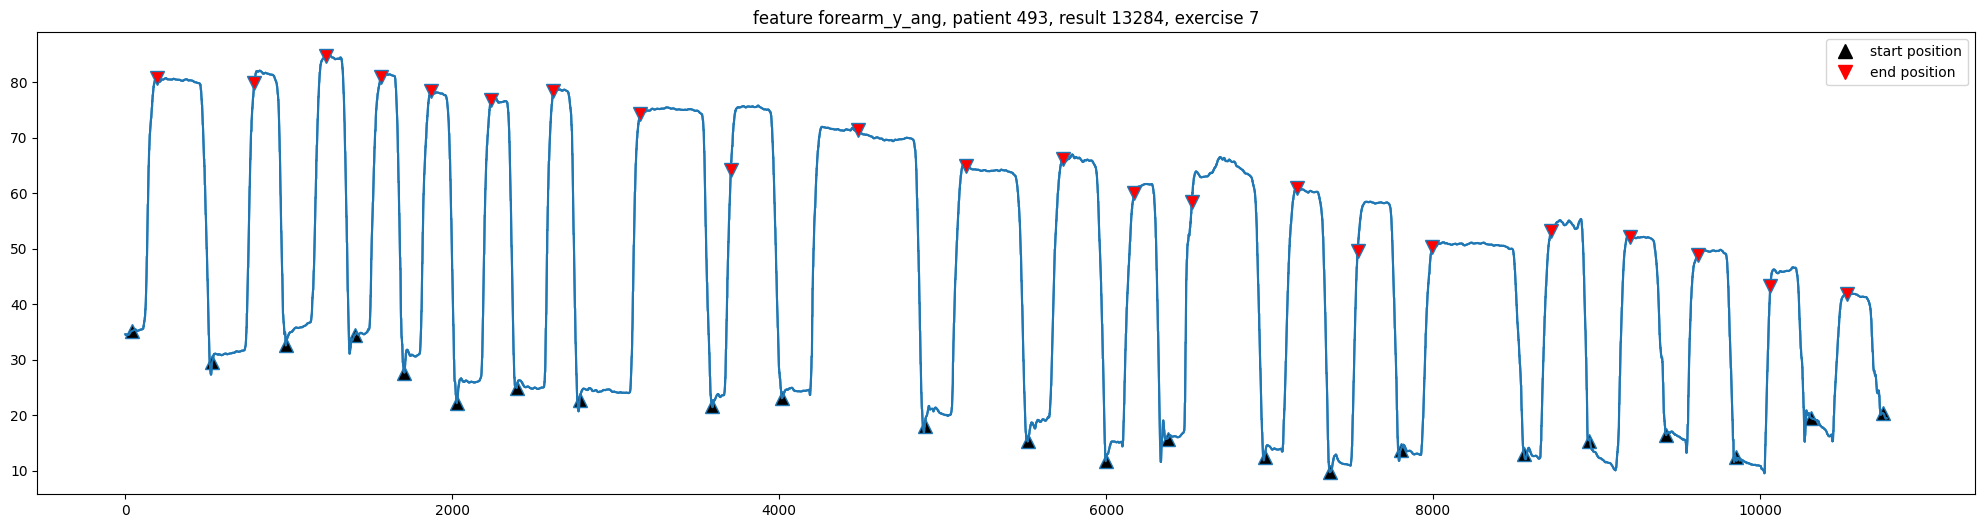

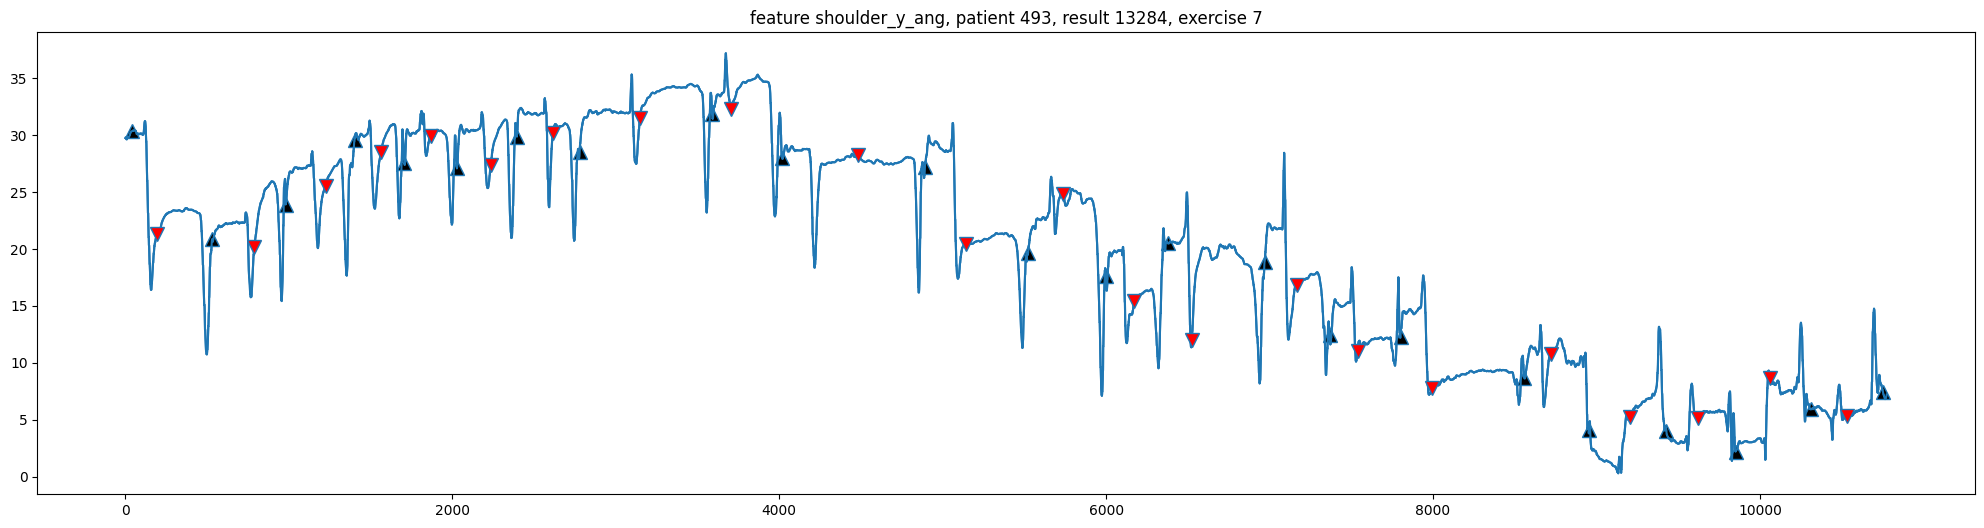

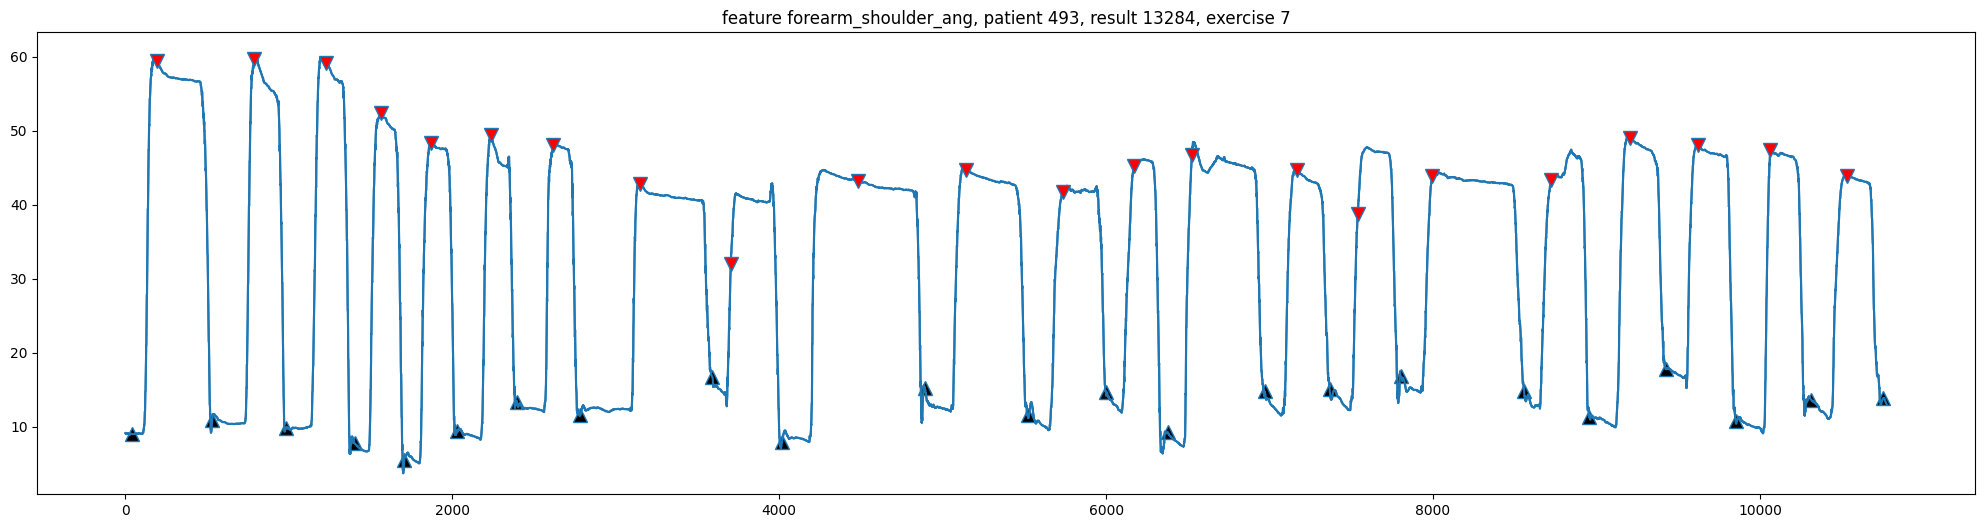

<Figure size 640x480 with 0 Axes>

In [24]:
plot_game_result(13284, 493)